## Lab - EDA Bivariate Analysis: Diving into Amazon UK Product Insights Part II

**Objective**: Delve into the dynamics of product pricing on Amazon UK to uncover insights that can inform business strategies and decision-making.

**Dataset**: This lab utilizes the [Amazon UK product dataset](https://www.kaggle.com/datasets/asaniczka/uk-optimal-product-price-prediction/)
which provides information on product categories, brands, prices, ratings, and more from from Amazon UK. You'll need to download it to start working with it.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os 
import glob 

%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
data_amz = pd.read_csv("amz_uk_price_prediction_dataset.csv")
df_amz   = data_amz.copy()

In [3]:
print(df_amz.columns)

Index(['uid', 'asin', 'title', 'stars', 'reviews', 'price', 'isBestSeller',
       'boughtInLastMonth', 'category'],
      dtype='object')


In [4]:
print(f"The Amazon UK Price dataset main dataframe shape is {df_amz.shape}")

The Amazon UK Price dataset main dataframe shape is (2443651, 9)


In [5]:
df_amz.head(3)

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers


In [6]:
df_amz.isnull().sum().sort_values(ascending=False)

uid                  0
asin                 0
title                0
stars                0
reviews              0
price                0
isBestSeller         0
boughtInLastMonth    0
category             0
dtype: int64

In [7]:
round(df_amz. describe().T, 2)

,count,mean,std,min,25%,50%,75%,max
uid,2443651.0,1370545.35,816056.17,1.0,658921.50,1349029.00,2060685.50,2828593.0
stars,2443651.0,2.15,2.19,0.0,0.00,0.00,4.40,5.0
reviews,2443651.0,480.63,5944.12,0.0,0.00,0.00,59.00,1356658.0
price,2443651.0,89.24,345.61,0.0,9.99,19.09,45.99,100000.0
boughtInLastMonth,2443651.0,25.90,240.48,0.0,0.00,0.00,0.00,50000.0


### Part 1: Analyzing Best-Seller Trends Across Product Categories

**Objective**: Understand the relationship between product categories and their best-seller status.

1. **Crosstab Analysis**:
    - Create a crosstab between the product `category` and the `isBestSeller` status.
    
    - Are there categories where being a best-seller is more prevalent? 
    	
    	*Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order.*

In [8]:
crosstab_result = pd.crosstab(df_amz['category'], df_amz['isBestSeller'])
crosstab_result

isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3
...,...,...
Wind Instruments,243,7
Window Treatments,234,5
Women,17559,213


2. **Statistical Tests**:
    - Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
    - Compute Cramér's V to understand the strength of association between best-seller status and category.

In [9]:
from scipy.stats import chi2_contingency

In [10]:
# Chi-square test for 'MSZoning' and 'SaleCondition'
_, chi2_pvalue, _, _  = chi2_contingency(crosstab_result)

In [11]:
float(chi2_pvalue) < 0.05

# If the p value is smaller than 0.05 (or alpha) we do have a correlation between 2 categorical variables
# Else, nothigness

True

In [12]:
from scipy.stats.contingency import association

In [13]:
# Computing the association between variables in 'crosstab_result' using the "cramer" method
print(round(association(crosstab_result, method='cramer'),2))

""" 
# INTERPRETATION:
# Range of Cramer's goes between 0-1: 0.12
# This is a weak correlation
"""

0.12


" \n# INTERPRETATION:\n# Range of Cramer's goes between 0-1: 0.12\n# This is a weak correlation\n"

3. **Visualizations**:
	- Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

In [32]:
sorted_crosstab = crosstab_result.sort_values(by=True, ascending=False)
sorted_crosstab_top20 = sorted_crosstab.head(20)
sorted_crosstab_top20

isBestSeller,False,True
category,,
Grocery,9008,556
Health & Personal Care,9017,552
Baby,14709,341
Sports & Outdoors,835935,330
Power & Hand Tools,8353,306
Beauty,19010,302
Pet Supplies,9152,285
Arts & Crafts,9319,230
Women,17559,213


In [41]:
crosstab_result.shape

(296, 2)

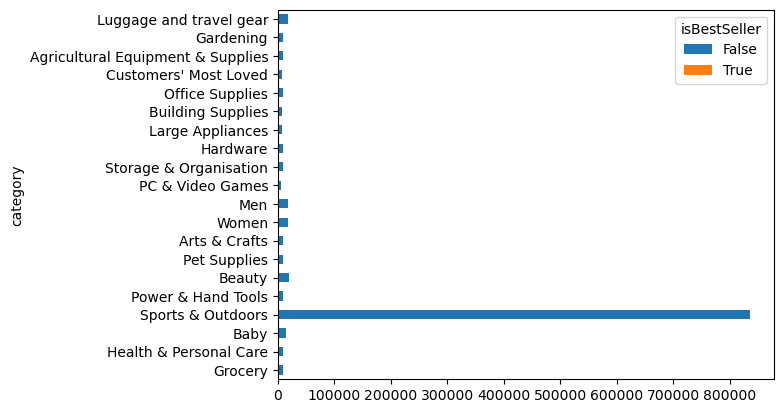

In [44]:
# Plotting a stacked bar chart for the 'crosstab_result' data
sorted_crosstab_top20.plot(kind='barh', stacked=True)
plt.show()

### Part 2: Exploring Product Prices and Ratings Across Categories and Brands

**Objective**: Investigate how different product categories influence product prices.

0. **Preliminary Step: Remove outliers in product prices.**

	For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.
	
	*Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.*

In [45]:
def outlier_slayer(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds for the outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify the outliers
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    
    return outliers

In [46]:
round(df_amz['price'].describe(),2)

count    2443651.00
mean          89.24
std          345.61
min            0.00
25%            9.99
50%           19.09
75%           45.99
max       100000.00
Name: price, dtype: float64

In [47]:
price_outliers = outlier_slayer(df_amz['price'])
print(type(price_outliers))
print(price_outliers)

<class 'pandas.core.series.Series'>
10         139.00
19         164.99
25         149.99
28         289.00
31         199.99
            ...  
2443619    166.99
2443627    152.58
2443638    108.77
2443641    166.99
2443643    158.99
Name: price, Length: 327688, dtype: float64


In [48]:
filtered_df = df_amz[~df_amz['price'].isin(price_outliers)]

print(filtered_df.columns)

Index(['uid', 'asin', 'title', 'stars', 'reviews', 'price', 'isBestSeller',
       'boughtInLastMonth', 'category'],
      dtype='object')


1. **Violin Plots**:
    - Use a violin plot to visualize the distribution of `price` across different product `categories`. Filter out the top 20 categories based on count for better visualization.
    - Which product category tends to have the highest median price? Don't filter here by top categories.

In [52]:
print(filtered_df["price"].describe())

count    2.115963e+06
mean     2.340827e+01
std      2.051335e+01
min      0.000000e+00
25%      9.130000e+00
50%      1.599000e+01
75%      2.999000e+01
max      9.999000e+01
Name: price, dtype: float64


In [61]:
mean_price_by_category = filtered_df.groupby('category')['price'].mean()
mean_price_by_category_df = mean_price_by_category.reset_index(name='mean_price')
mean_price_by_category_df = mean_price_by_category_df.sort_values(by='mean_price', ascending=False).reset_index(drop=True)
print(mean_price_by_category_df)


                  category  mean_price
0             Motherboards   68.772432
1             Boxing Shoes   67.417803
2              Desktop PCs   66.915562
3                  Tablets   66.552971
4           Graphics Cards   65.103509
..                     ...         ...
291    Bedding Accessories    8.835220
292               Adapters    8.750197
293        Signs & Plaques    8.210513
294          Arts & Crafts    8.006540
295  Office Paper Products    6.876369

[296 rows x 2 columns]


In [62]:
mean_price_by_category_df_top20 = mean_price_by_category_df.head(20)
mean_price_by_category_df_top20

,category,mean_price
0,Motherboards,68.772432
1,Boxing Shoes,67.417803
2,Desktop PCs,66.915562
3,Tablets,66.552971
4,Graphics Cards,65.103509
5,Digital Frames,60.745129
6,Streaming Clients,60.241803
7,Hockey Shoes,60.094796
8,Computer Cases,58.339884
9,Skiing Poles,57.867770


In [64]:
products_top20 = list(mean_price_by_category_df_top20["category"])
print(products_top20)

['Motherboards', 'Boxing Shoes', 'Desktop PCs', 'Tablets', 'Graphics Cards', 'Digital Frames', 'Streaming Clients', 'Hockey Shoes', 'Computer Cases', 'Skiing Poles', 'Ski Helmets', 'Made in Italy Handmade', 'Home Office Furniture', '3D Printers', 'Motorbike Batteries', 'Golf Shoes', 'Alexa Built-In Devices', 'Dining Room Furniture', 'Motorbike Handlebars, Controls & Grips', "Men's Sports & Outdoor Shoes"]


In [65]:
filtered_top20_df = filtered_df[filtered_df['category'].isin(products_top20)]

filtered_top20_df.head(5)

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
18933,20489,B07WZZMH3Q,PTX9-BS Powerline Factory Sealed Motorcycle Ba...,4.6,631,26.99,True,200,Motorbike Batteries
18934,20490,B01MTNHX72,GP-PRO Gel Battery 12V 5Ah GTX4L-BS (similar t...,4.1,6590,19.98,False,100,Motorbike Batteries
18935,20491,B07SC1H964,YB9-B AGM Powerline Factory Sealed Motorcycle ...,4.7,108,27.49,False,50,Motorbike Batteries
18936,20492,B0C3HXK1XL,Vertex VPZ5-S Sealed AGM Motorcycle/Powersport...,4.3,5,24.99,False,0,Motorbike Batteries
18937,20493,B07SC37FK9,YB14L-A2 AGM Powerline Factory Sealed Motorcyc...,4.5,118,36.22,False,50,Motorbike Batteries


/var/folders/f1/x77kh9w17j56ckntc3dq_ztm0000gn/T/ipykernel_10490/932064068.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=filtered_top20_df, y="category", x="price", palette="coolwarm")


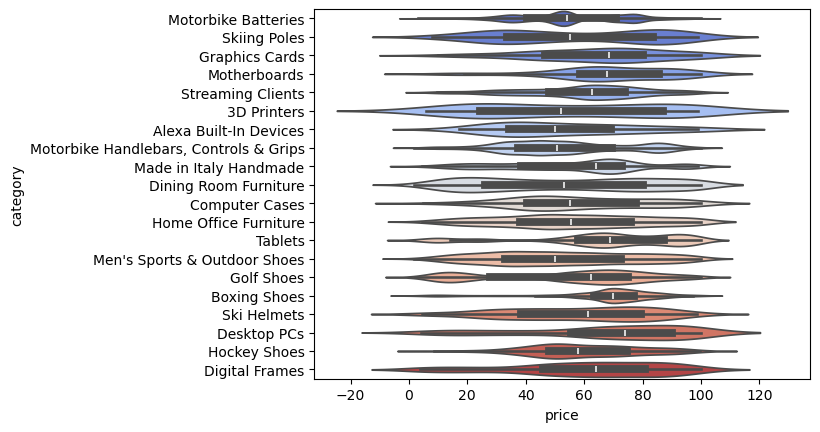

In [67]:
# Plotting a violin plot to visualize the distribution of 'price' for each 'category' category, using the "coolwarm" color palette
sns.violinplot(data=filtered_top20_df, y="category", x="price", palette="coolwarm")
plt.show()

In [69]:
median_price_by_category = filtered_df.groupby('category')['price'].median()
median_price_by_category_df = median_price_by_category.reset_index(name='median_price')
median_price_by_category_df = median_price_by_category_df.sort_values(by='median_price', ascending=False).reset_index(drop=True)
print(median_price_by_category_df)

                  category  median_price
0              Desktop PCs         74.00
1             Boxing Shoes         69.79
2                  Tablets         69.00
3           Graphics Cards         68.54
4             Motherboards         67.92
..                     ...           ...
291               Adapters          7.05
292                Make-up          7.00
293        Signs & Plaques          6.99
294          Arts & Crafts          5.99
295  Office Paper Products          4.37

[296 rows x 2 columns]


2. **Bar Charts**:
    - Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
    - Which product category commands the highest average price? Don't filter here by top categories.

In [70]:
mean_price_by_category_df_top10 = mean_price_by_category_df.head(10)
mean_price_by_category_df_top10

,category,mean_price
0,Motherboards,68.772432
1,Boxing Shoes,67.417803
2,Desktop PCs,66.915562
3,Tablets,66.552971
4,Graphics Cards,65.103509
5,Digital Frames,60.745129
6,Streaming Clients,60.241803
7,Hockey Shoes,60.094796
8,Computer Cases,58.339884
9,Skiing Poles,57.867770


In [71]:
products_top10 = list(mean_price_by_category_df_top10["category"])
filtered_top10_df = filtered_df[filtered_df['category'].isin(products_top10)]

filtered_top10_df.head(5)

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
207565,221913,B07BRG8GCP,Salomon X North Unisex Aluminium Ski and Winte...,4.5,148,20.00,False,0,Skiing Poles
207566,221914,B07BRBDVSM,SALOMON X North Unisex Poles Ski Hiking,4.4,113,24.98,False,0,Skiing Poles
207567,221915,B07BRG8CKT,Salomon Arctic Unisex Poles Ski Hiking 110cm,4.2,28,35.00,False,0,Skiing Poles
207568,221916,B092Z9PSVD,SALOMON Arctic Unisex Poles Ski Hiking,4.4,19,30.00,False,0,Skiing Poles
207569,221917,B07BRG8F4T,Salomon X North Unisex Aluminium Ski Poles and...,4.0,23,24.48,False,0,Skiing Poles


/var/folders/f1/x77kh9w17j56ckntc3dq_ztm0000gn/T/ipykernel_10490/2912439063.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_top10_df, y="category", x="price", palette="coolwarm", errorbar=None)


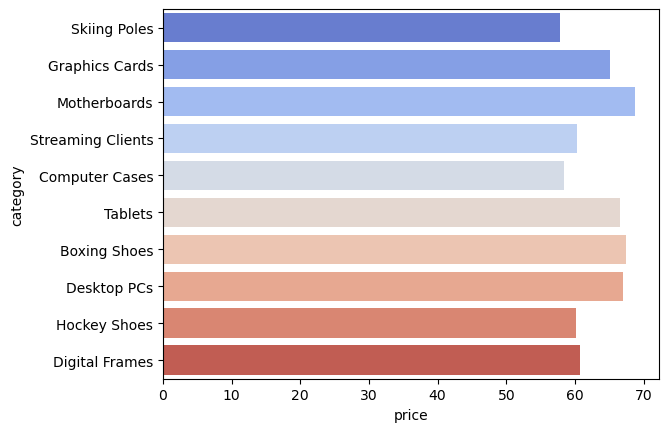

In [73]:
sns.barplot(data=filtered_top10_df, y="category", x="price", palette="coolwarm", errorbar=None)
plt.show()

3. **Box Plots**:
    - Visualize the distribution of product `ratings` based on their `category` using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
    - Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

In [79]:
filtered_df["stars"].describe()

count    2.115963e+06
mean     2.275402e+00
std      2.193863e+00
min      0.000000e+00
25%      0.000000e+00
50%      3.400000e+00
75%      4.400000e+00
max      5.000000e+00
Name: stars, dtype: float64

In [80]:
mean_rating_by_category = filtered_df.groupby('category')['stars'].mean()
mean_rating_by_category_df = mean_rating_by_category.reset_index(name='mean_rating')
mean_rating_by_category_df = mean_rating_by_category_df.sort_values(by='mean_rating', ascending=False).reset_index(drop=True)
print(mean_rating_by_category_df)

                                   category  mean_rating
0                       Luxury Food & Drink     4.544140
1                                   Grocery     4.469414
2                        Laptop Accessories     4.449600
3                    Health & Personal Care     4.439549
4                             Arts & Crafts     4.432942
..                                      ...          ...
291                            Boxing Shoes     0.160470
292  Motorbike Handlebars, Controls & Grips     0.134289
293        Motorbike Electrical & Batteries     0.105697
294                  3D Printing & Scanning     0.094067
295                 CD, Disc & Tape Players     0.048834

[296 rows x 2 columns]


In [81]:
mean_rating_by_category_df_top10 = mean_rating_by_category_df.head(10)
mean_rating_by_category_df_top10

,category,mean_rating
0,Luxury Food & Drink,4.544140
1,Grocery,4.469414
2,Laptop Accessories,4.449600
3,Health & Personal Care,4.439549
4,Arts & Crafts,4.432942
5,Office Paper Products,4.430000
6,Customers' Most Loved,4.404388
7,"Water Coolers, Filters & Cartridges",4.394505
8,USB Hubs,4.357430
9,Power & Hand Tools,4.351565


In [82]:
products_rating_top10 = list(mean_rating_by_category_df_top10["category"])
filtered_rating_top10_df = filtered_df[filtered_df['category'].isin(products_rating_top10)]

filtered_rating_top10_df.head(5)

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
543208,585878,B004UWZ090,Ahmad Tea Twelve Teas Selection Pack | Black /...,4.6,10980,6.75,False,300,Luxury Food & Drink
543209,585879,B00HYFNWZ4,"Ultimate Treats Gift Hamper - Chocolates, Swee...",4.5,361,38.00,False,200,Luxury Food & Drink
543210,585880,B015J4PRTU,Galaxy Smooth Caramel & Milk Chocolate Bar 135g,4.7,5684,1.25,True,4000,Luxury Food & Drink
543211,585881,B08FS9KY9R,Lindt Lindor Milk Chocolate Christmas Advent C...,4.2,2124,5.00,True,3000,Luxury Food & Drink
543212,585882,B00NW479QO,Lindt Lindor Milk Chocolate Truffles Box - App...,4.7,82169,4.25,True,6000,Luxury Food & Drink


/var/folders/f1/x77kh9w17j56ckntc3dq_ztm0000gn/T/ipykernel_10490/2334879236.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_rating_top10_df, x="stars", y="category", palette="coolwarm")


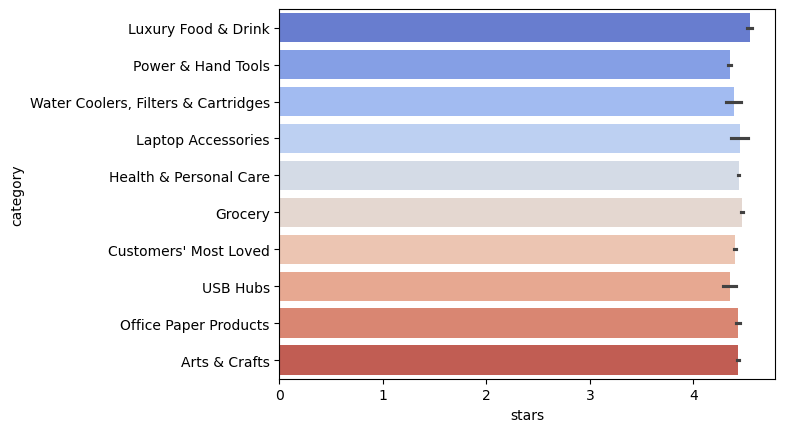

In [85]:
sns.barplot(data=filtered_rating_top10_df, x="stars", y="category", palette="coolwarm")
plt.show()

In [86]:
median_rating_by_category = filtered_df.groupby('category')['stars'].median()
median_rating_by_category_df = median_rating_by_category.reset_index(name='median_rating')
median_rating_by_category_df = median_rating_by_category_df.sort_values(by='median_rating', ascending=False).reset_index(drop=True)
print(median_rating_by_category_df)

                         category  median_rating
0                 Computer Memory            4.7
1    Building & Construction Toys            4.6
2           Office Paper Products            4.6
3             Luxury Food & Drink            4.6
4              Kids' Play Figures            4.6
..                            ...            ...
291                  Hockey Shoes            0.0
292   Hi-Fi Receivers & Separates            0.0
293     Handmade Kitchen & Dining            0.0
294            Handmade Jewellery            0.0
295   eBook Readers & Accessories            0.0

[296 rows x 2 columns]


In [87]:
median_rating_by_category_df_top10 = median_rating_by_category_df.head(10)
median_rating_by_category_df_top10

,category,median_rating
0,Computer Memory,4.7
1,Building & Construction Toys,4.6
2,Office Paper Products,4.6
3,Luxury Food & Drink,4.6
4,Kids' Play Figures,4.6
5,Hobbies,4.6
6,"Beer, Wine & Spirits",4.6
7,Laptop Accessories,4.6
8,Cables & Accessories,4.5
9,CPUs,4.5


### Part 3: Investigating the Interplay Between Product Prices and Ratings

**Objective**: Analyze how product ratings (`stars`) correlate with product prices.

1. **Correlation Coefficients**:
    - Calculate the correlation coefficient between `price` and `stars`.
    - Is there a significant correlation between product price and its rating?

In [90]:
cor_pearson = round(float(filtered_df["price"].corr(filtered_df["stars"], method="pearson")), 2)
cor_spearman = round(float(filtered_df["price"].corr(filtered_df["stars"], method="spearman")), 2)
print(cor_pearson, cor_spearman, "Small negative relationship")


-0.08 -0.07 Small negative relationship


2. **Visualizations**:
    - Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?

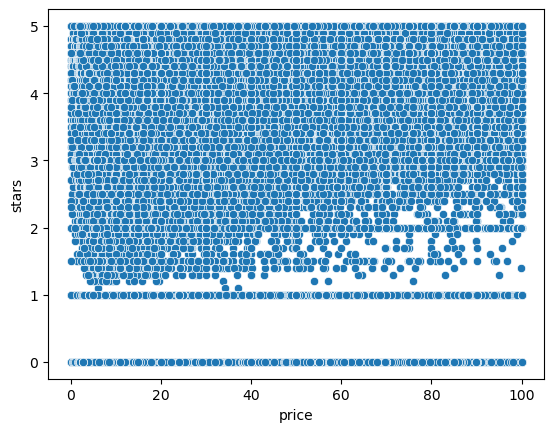

In [92]:
sns.scatterplot(data=filtered_df, x='price', y='stars')
plt.show()

 - Use a correlation heatmap to visualize correlations between all numerical variables.

In [94]:
# filtering all numerical variables
num = filtered_df.select_dtypes(include="number") 

# correlation matrix
correlation_matrix = num.corr()

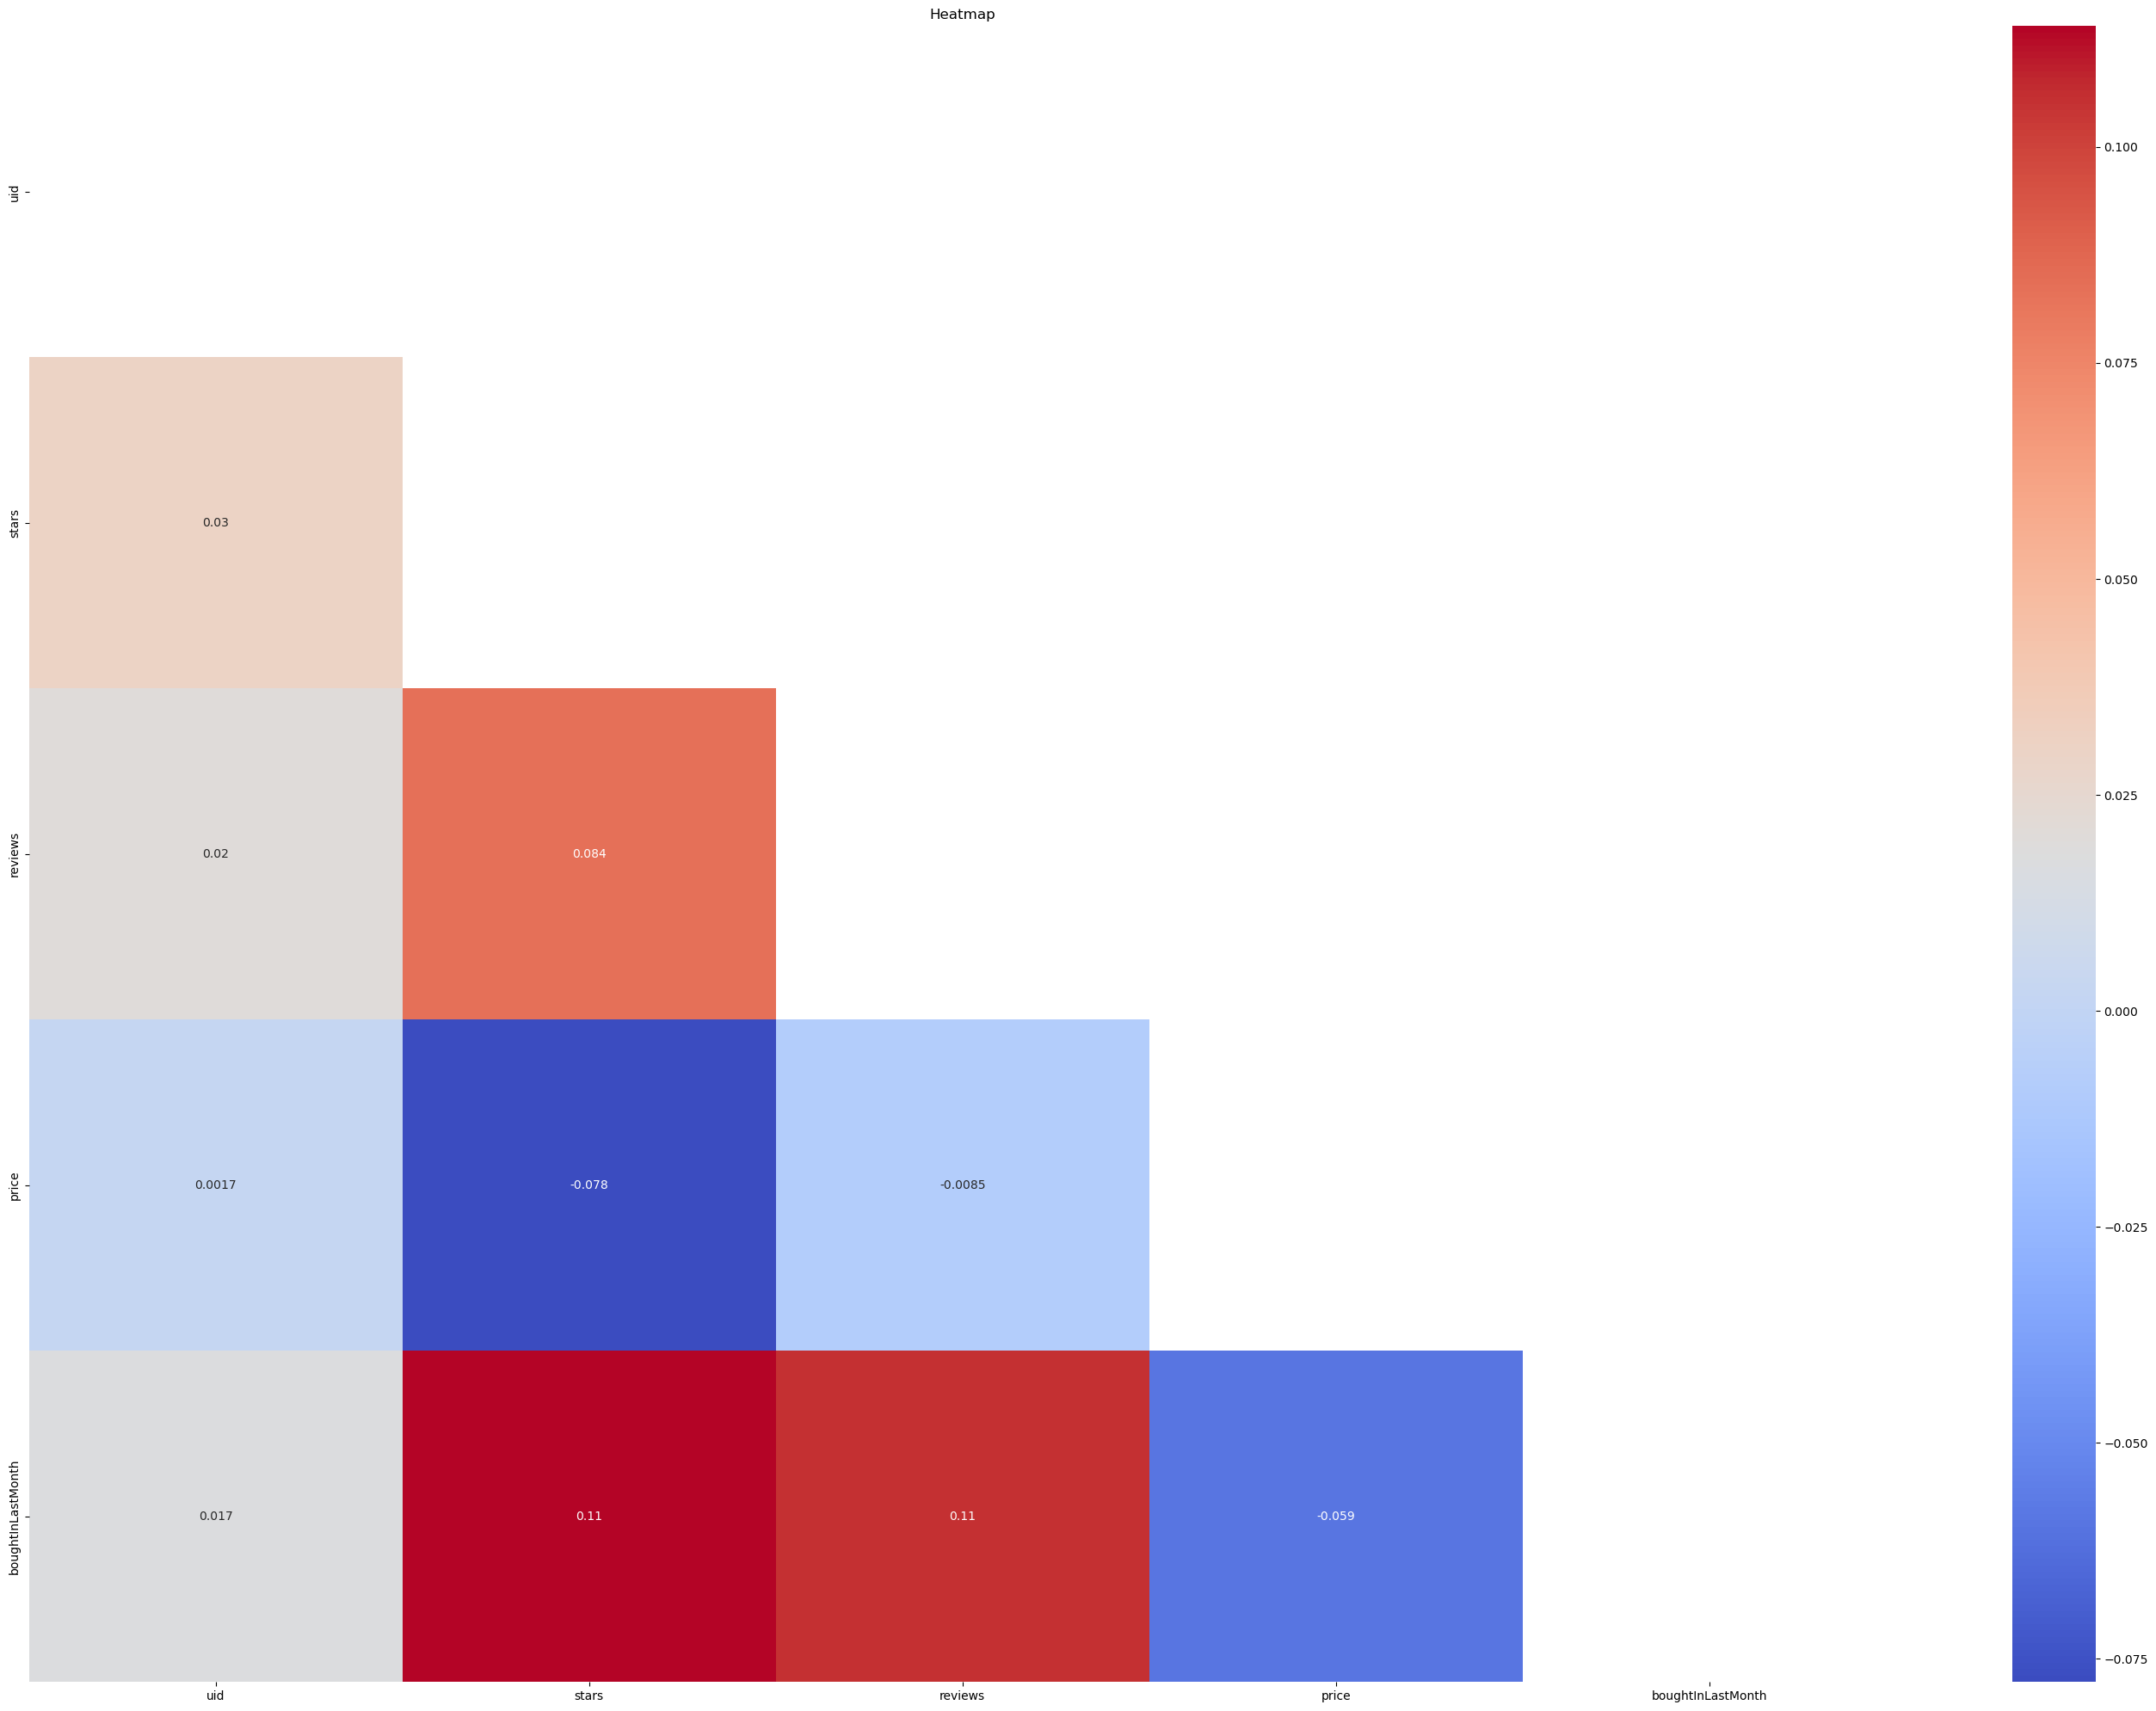

In [95]:
# Heatmap
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(35, 25))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap="coolwarm")

plt.title("Heatmap")
plt.show()

- Examine if product prices typically follow a normal distribution using a QQ plot. 

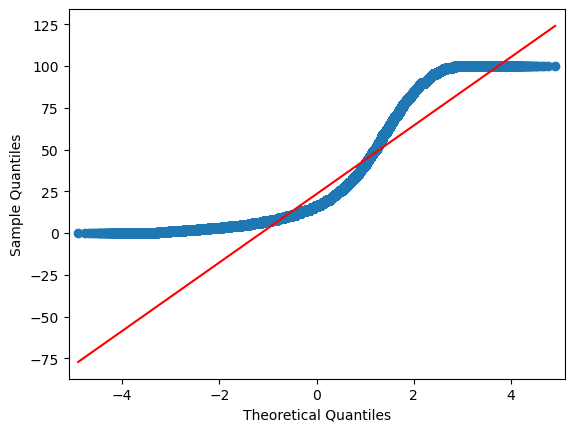

In [97]:
import statsmodels.api as sm

# Generating a Q-Q plot for 'price' to check if its distribution follows a normal distribution
sm.qqplot(num['price'], line='s');
plt.show()